# Analysis 3: Semi-Supervised Isolation Forest and Semi-Supervised XGBoost

# Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, average_precision_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.utils import resample

np.random.seed(42)


# Loading Datasets

In [3]:
# Load the datasets
df_train = pd.read_csv('D_train.csv')
df_val = pd.read_csv('D_val.csv')

In [4]:
df_train

,step,customer,merchant,category,fraud,'M348934600'_min,'M348934600'_max,'M348934600'_mean,'M348934600'_median,'M348934600'_std,...,period,category_frequency,category_monetary,merchant_frequency,merchant_monetary,category_z_score,category_robust_z_score,merchant_z_score,merchant_robust_z_score,amount_log
0,1.528062,0.917476,0.714000,0.331409,0,0.364340,-1.526470,-1.335635,-1.477966,-0.581294,...,1.381665,0.077467,-0.176252,-1.919028,-1.607152,-8.891184e-01,-0.073328,-1.047313e+00,-0.069424,-0.779650
1,1.293017,0.526921,2.460167,-2.863311,0,1.715916,0.100998,0.460804,0.497436,-0.305121,...,1.381665,-2.271491,-1.929376,-1.919028,-1.689644,1.030481e+00,0.043296,1.047313e+00,0.044404,0.213308
2,1.625998,1.298753,-0.682934,0.331409,0,0.491662,0.937235,0.652457,0.606729,0.912044,...,1.381665,0.312363,-0.232114,0.299356,-0.105135,-6.591163e-01,-0.053871,-6.979022e-01,-0.051616,-0.738566
3,-0.293542,1.474208,0.714000,0.331409,0,-0.389801,0.448669,0.194336,0.241817,0.245294,...,-0.403092,0.899603,0.381662,1.075791,0.575904,2.950636e-04,-0.011125,2.998833e-04,-0.010818,0.103452
4,-1.057440,-1.580223,0.714000,0.331409,0,0.080313,-0.546728,1.290341,2.265091,0.376461,...,-0.998011,-0.392325,-0.149892,-0.698916,-0.346283,-1.753945e+00,-0.135478,-1.984067e+00,-0.180201,-2.129834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356749,-0.567762,1.226209,0.714000,0.331409,0,-0.308184,-0.220582,0.549827,1.132418,0.060453,...,-0.403092,0.312363,0.150068,0.521195,0.348869,2.175697e+00,0.153732,2.211236e+00,0.156464,0.975132
356750,0.137375,-1.698317,1.179645,-2.508342,1,-0.011098,-0.141003,-0.103109,0.009682,-0.361811,...,0.191827,-2.388939,-0.760593,-2.029947,-0.543867,2.055728e-18,-0.012793,-1.190538e-18,-0.012510,2.576613
356751,1.214668,-1.032770,2.460167,-2.863311,0,-0.115568,0.753941,0.396982,0.173170,0.549568,...,1.381665,-2.388939,-1.774327,-2.029947,-1.537647,2.055728e-18,-0.012793,-1.190538e-18,-0.012510,1.109687
356752,-1.253312,0.407139,0.830411,-3.218280,0,-0.131891,-0.060118,-0.044123,-0.195355,0.325736,...,-0.998011,-2.271491,-1.898860,-2.029947,-1.679274,1.030481e+00,0.043296,-1.190538e-18,-0.012510,0.333940


# Calculating & selecting correlations

In [5]:
def select_train_cols(df, target_column, threshold=0.2):
    # # Copy the original DataFrame
    # df = df.copy()
    
    # Calculate the correlation with the target variable
    label_corr = df.corr()[target_column]
    
    # Select columns with correlation above the threshold
    train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > threshold)]
    train_cols = list(train_cols.index)
    
    return train_cols

In [6]:
train_cols = select_train_cols(df_train, 'fraud')

train_cols.append('step')

df_train_cols = df_train[train_cols]

train_cols

['fraud',
 "'M50039827'_sum",
 "'M1888755466'_max",
 "'M1888755466'_sum",
 "'M480139044'_max",
 "'M480139044'_std",
 "'M480139044'_count",
 "'M480139044'_sum",
 "'M840466850'_sum",
 "'M1741626453'_std",
 "'M1741626453'_count",
 "'M1741626453'_sum",
 "'M1535107174'_sum",
 "'M2122776122'_max",
 "'M2122776122'_std",
 "'M2122776122'_count",
 "'M2122776122'_sum",
 "'M1873032707'_max",
 "'M1873032707'_std",
 "'M1873032707'_count",
 "'M1873032707'_sum",
 "'M2011752106'_max",
 "'M2011752106'_mean",
 "'M2011752106'_median",
 "'M2011752106'_std",
 "'M2011752106'_count",
 "'M2011752106'_sum",
 "'M857378720'_std",
 "'M857378720'_count",
 "'M857378720'_sum",
 "'M1198415165'_max",
 "'M1198415165'_count",
 "'M1198415165'_sum",
 "'M980657600'_max",
 "'M980657600'_std",
 "'M980657600'_count",
 "'M980657600'_sum",
 "'M547558035'_max",
 "'M547558035'_std",
 "'M547558035'_count",
 "'M547558035'_sum",
 "'M17379832'_max",
 "'M17379832'_std",
 "'M17379832'_count",
 "'M17379832'_sum",
 "'M923029380'_count",
 

In [7]:
df_train_cols

,fraud,'M50039827'_sum,'M1888755466'_max,'M1888755466'_sum,'M480139044'_max,'M480139044'_std,'M480139044'_count,'M480139044'_sum,'M840466850'_sum,'M1741626453'_std,...,'es_leisure'_max,'es_leisure'_mean,'es_leisure'_median,'es_leisure'_std,'es_leisure'_count,'es_leisure'_sum,category_frequency,merchant_frequency,amount_log,step
0,0,-0.193143,-0.243131,-0.229441,2.934064,-0.277417,0.211311,0.771682,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.077467,-1.919028,-0.779650,1.528062
1,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.271491,-1.919028,0.213308,1.293017
2,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.312363,0.299356,-0.738566,1.625998
3,0,-0.193143,-0.243131,-0.229441,3.149942,3.008618,1.214548,2.343511,5.089803,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.899603,1.075791,0.103452,-0.293542
4,0,-0.193143,6.619753,5.299477,3.816500,4.256655,3.221023,5.342679,3.180184,-0.081963,...,5.894705,4.680477,4.839599,10.151894,7.282900,8.686959,-0.392325,-0.698916,-2.129834,-1.057440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356749,0,-0.193143,3.299419,2.624530,-0.386785,-0.277417,-0.290308,-0.218117,0.134384,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.312363,0.521195,0.975132,-0.567762
356750,1,-0.193143,0.989820,0.763856,1.345375,-0.277417,0.211311,0.298164,-0.082739,-0.081963,...,4.887399,5.221173,5.210876,-0.107288,1.678434,2.279758,-2.388939,-2.029947,2.576613,0.137375
356751,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,1.614606,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.388939,-2.029947,1.109687,1.214668
356752,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,1.267948,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.271491,-2.029947,0.333940,-1.253312


In [36]:
df_sort = df_train_cols.sort_values('step')

df_sort['fraud'].value_counts()

fraud
0    352434
1      4320
Name: count, dtype: int64

# Creating Datasets per percentage labelled

In [96]:
def split_and_label(df_sort, label_splits, n=30000):   
    df_sort.sort_values('step')
    df_sort = df_sort.drop(columns=['step'])

    step = int(len(df_sort) / 6)
    
    # Generate step indices
    steps = [step * i for i in range(1, 6)]
    
    # Split the dataframe
    df_splits = [df_sort.iloc[:steps[0]].copy()]
    for i in range(1, len(steps)):
        df_splits.append(df_sort.iloc[steps[i-1]:steps[i]].copy())
    df_splits.append(df_sort.iloc[steps[-1]:].copy())
    
    # Label the dataframes
    for i, df_split in enumerate(df_splits):
        if i < label_splits:
            df_split.loc[:, 'Labelled'] = 1
        else:
            df_split.loc[:, 'Labelled'] = 0
            
    # Concatenate the dataframes
    result_df = pd.concat(df_splits)

    sample_result_df = result_df.sample(n=n, random_state=42)
        
    return sample_result_df

df_1 = split_and_label(df_sort, 1)
df_2 = split_and_label(df_sort, 2)
df_3 = split_and_label(df_sort, 3)
df_4 = split_and_label(df_sort, 4)
df_5 = split_and_label(df_sort, 5)


In [97]:
df_t = df_1[df_1['Labelled'] == 0]

df_t['fraud'].value_counts()

fraud
0    24692
1      305
Name: count, dtype: int64

# Plotting Distribution of first two datasets

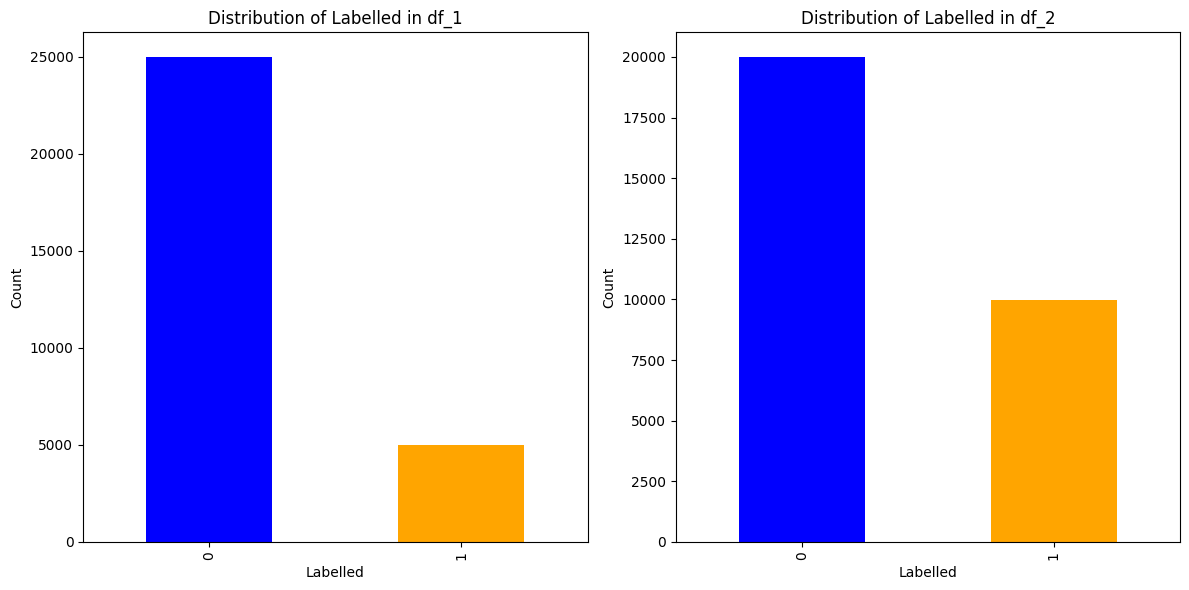

In [76]:
# Plotting the distribution of 'Labelled' for df_1 and df_2
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df_1['Labelled'].value_counts().plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Distribution of Labelled in df_1')
axes[0].set_xlabel('Labelled')
axes[0].set_ylabel('Count')

df_2['Labelled'].value_counts().plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Distribution of Labelled in df_2')
axes[1].set_xlabel('Labelled')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Calculating Baseline

### Function for calculating baseline

In [98]:
def evaluate_baseline_model(df):
    y_true = df['fraud']
    
    y_pred = np.random.choice([0, 1], size=len(y_true), p=[1 - 0.0124, 0.0124])
    
    print("Unique values in y_true after filtering:", np.unique(y_true))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    precision_values, recall_values, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall_values, precision_values)
    
    return  auc_pr, precision, recall 


### Excecute baseline per dataset

In [100]:
datasets = [df_1, df_2, df_3, df_4, df_5] #, D_train_0_6p_label, D_train_0_9p_label, D_train_1_2p_label]
dataset_names = ['1','2','3','4','5'] #, 'D_train_0_6p', 'D_train_0_9p', 'D_train_1_2p']

results_baseline = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall = evaluate_baseline_model(df_train)    
    results_baseline.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})
    
results_baseline_df = pd.DataFrame(results_baseline)

Processing dataset 1/5: 1
Unique values in y_true after filtering: [0 1]
Processing dataset 2/5: 2
Unique values in y_true after filtering: [0 1]
Processing dataset 3/5: 3
Unique values in y_true after filtering: [0 1]
Processing dataset 4/5: 4
Unique values in y_true after filtering: [0 1]
Processing dataset 5/5: 5
Unique values in y_true after filtering: [0 1]


### Results Baseline

In [101]:
results_baseline_df

,Dataset,AUC-PR,Precision,Recall
0,1,0.009002,0.002950,0.002688
1,2,0.029453,0.022613,0.024194
2,3,0.019631,0.013587,0.013441
3,4,0.024559,0.018135,0.018817
4,5,0.024353,0.017722,0.018817


----

# Semi-Supervised XGBoost

### Algorithm for Semi-Supervised XGBoost

In [77]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score

def self_learning_xgboost(df_train, L0, U0, df_val, params, MaxIter=256, T=0.1, num_boost_round=100):
    """
    Self-learning XGBoost algorithm with evaluation phase.
    
    Parameters:
    L0 : ndarray
        Initial set of labelled training instances.
    U0 : ndarray
        Initial set of unlabelled training instances.
    df_val : DataFrame
        Validation dataset for evaluation.
    params : dict
        Parameters for the XGBoost model.
    MaxIter : int, optional
        Maximum number of iterations for self-training.
    T : float, optional
        Percentage of instances to accept per iteration.
    num_boost_round : int, optional
        Number of boosting rounds for XGBoost.
    
    Returns:
    dict
        Evaluation metrics (AUC-PR, Precision, Recall).
    """
    
    # Initialize labelled and unlabelled sets
    Li = L0.copy()
    Ui = U0.copy()
    
    original_columns = Li.columns
    label_dtype = Li.iloc[:, 0].dtype
    
    # Extract features and labels from the initial labelled set
    X_Li = Li.iloc[:, 1:]
    y_Li = Li.iloc[:, 0]
    
    # Train initial XGBoost model
    dtrain = xgb.DMatrix(X_Li, label=y_Li)
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Self-training iterations
    for i in range(MaxIter):
        if len(Ui) == 0:
            break
        
        # Predict on unlabelled set
        X_Ui = Ui.iloc[:, 1:]
        dtest = xgb.DMatrix(X_Ui)
        preds = model.predict(dtest)
        
        # Sort predictions by confidence
        sorted_indices = np.argsort(preds)[::-1]
        sorted_Ui = Ui.iloc[sorted_indices]
        sorted_preds = preds[sorted_indices]
        
        # Select top T% most confident predictions
        num_to_select = int(T * len(L0))
        selected_Ui = sorted_Ui.iloc[:num_to_select].copy()
        selected_preds = sorted_preds[:num_to_select]
        
        # Add selected instances to labelled set
        selected_Ui.iloc[:, 0] = selected_preds.astype(label_dtype)
        Li = pd.concat([Li, selected_Ui])
        
        # Remove selected instances from unlabelled set
        Ui = sorted_Ui.iloc[num_to_select:]
        
        # Retrain XGBoost model on augmented labelled set
        X_Li = Li.iloc[:, 1:]
        y_Li = Li.iloc[:, 0]
        dtrain = xgb.DMatrix(X_Li, label=y_Li)
        model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    
    # Ensure the final DataFrame has the correct column names
    Li.columns = original_columns

    

    # # Evaluate the final model
    auc_pr, precision, recall = train_and_evaluate_xgb(Li, df_val, params, num_boost_round)
    
    return {'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall}

def train_and_evaluate_xgb(df_train, df_val, params, num_boost_round=100):
    """
    Train and evaluate XGBoost model.
    
    Parameters:
    df_train : DataFrame
        Training dataset.
    df_val : DataFrame
        Validation dataset.
    params : dict
        Parameters for the XGBoost model.
    num_boost_round : int, optional
        Number of boosting rounds.
    
    Returns:
    tuple
        AUC-PR, Precision, Recall.
    """
    
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_val = df_val[common_cols]
    
    # Remove the 'fraud' column to create feature matrices
    X_train = df_train[common_cols].drop(columns = ['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns = ['fraud'])
    y_val = df_val['fraud']

    # Create DMatrix for training and validation
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Predict probabilities
    y_pred_prob = model.predict(dval)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall, precision)

    # Determine the threshold for binary classification
    threshold = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred, zero_division=0)

    return auc_pr, precision_score_val, recall_score_val


### Parameters for XGBoost

In [78]:
# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

In [81]:
print(df_2.shape)

(30000, 95)


### Excecuting Semi-supervised XGBoost for all 5 datasets

In [82]:
datasets = [df_1, df_2, df_3, df_4, df_5] #, D_train_0_6p_label, D_train_0_9p_label, D_train_1_2p_label]
dataset_names = ['1','2','3','4','5'] #, 'D_train_0_6p', 'D_train_0_9p', 'D_train_1_2p']

results_ss_xgb = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    L0 = df_train[df_train['Labelled'] == 1]
    U0 = df_train[df_train['Labelled'] == 0]
    evaluation_metrics = self_learning_xgboost(df_train, L0, U0, df_val, params)
    evaluation_metrics['Dataset'] = dataset_names[i]
    results_ss_xgb.append(evaluation_metrics)

# Create a DataFrame to store the results
results_ss_xgb_df = pd.DataFrame(results_ss_xgb)

Processing dataset 1/5: 1
Processing dataset 2/5: 2
Processing dataset 3/5: 3
Processing dataset 4/5: 4
Processing dataset 5/5: 5


### Results of semi-supervised XGBoost

In [84]:
results_ss_xgb_df

,AUC-PR,Precision,Recall,Dataset
0,0.520587,0.340678,0.837500,1
1,0.583385,0.350922,0.859028,2
2,0.645117,0.305281,0.899306,3
3,0.656968,0.283244,0.921528,4
4,0.681274,0.285868,0.921528,5


----

# Semi-supervised Isolation Forest

### Import the SSIF.py file

In [85]:
from SSIF import *

### Algorithm to excecute semi-supervised Isolation Forest

In [86]:
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score
import numpy as np

def train_and_evaluate_ss_iforest(df_train, df_val, fraud_percentage):
    df_train['fraud'] = df_train.apply(lambda row: 0 if row['Labelled'] == 0 else (1 if row['fraud'] == 1 else -1), axis=1)    

    # Separate features and labels
    X_train = df_train.drop(columns=['fraud', 'Labelled'])
    y_train = df_train['fraud']

    common_columns = [col for col in X_train.columns if col in df_val.columns and col not in ['fraud', 'Labelled']]

    X_val = df_val[common_columns]
    y_val = df_val['fraud']

    # Convert to numpy arrays and use efficient data types
    X_train = X_train[common_columns].to_numpy().astype(np.float32)
    y_train = y_train.to_numpy().astype(np.int8)
    X_val = X_val.to_numpy().astype(np.float32)
    y_val = y_val.to_numpy().astype(np.int8)

    # Initialize SSIF with the correct training data
    ssif = SSIF(X_train, y_train)

    scores_val = ssif.compute_anomaly_scores(X_val)

    # Calculate the threshold based on the desired fraud percentage in the validation set
    sorted_scores = np.sort(scores_val)
    threshold_index = int((1 - fraud_percentage) * len(sorted_scores))
    threshold = sorted_scores[threshold_index]

    y_pred_val = np.where(scores_val >= threshold, 1, 0)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, scores_val)
    auc_pr = auc(recall, precision)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred_val, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred_val, zero_division=0)

    return auc_pr, precision_score_val, recall_score_val, threshold


### Excecute semi-supervised Isolation Forest

In [88]:
datasets = [df_1, df_2, df_3, df_4, df_5] 
dataset_names = ['1','2','3','4','5'] 
fraud_percentage = len(df_1[df_1['fraud'] == 1]) / len(df_1)

print(fraud_percentage)
results_ss_ifo = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall, threshold = train_and_evaluate_ss_iforest(df_train, df_val, fraud_percentage)
    # print(f"threshold {threshold}")
    results_ss_ifo.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})
    
    
results_ss_ifo_df = pd.DataFrame(results_ss_ifo)

0.0124
Processing dataset 1/5: 1
Processing dataset 2/5: 2
Processing dataset 3/5: 3
Processing dataset 4/5: 4
Processing dataset 5/5: 5


### Results semi-supervised Isolation Forest

In [90]:
results_ss_ifo_df

,Dataset,AUC-PR,Precision,Recall
0,1,0.395604,0.418964,0.432639
1,2,0.464398,0.476610,0.488194
2,3,0.511385,0.512162,0.526389
3,4,0.553325,0.552168,0.565972
4,5,0.582248,0.580339,0.594444


# Final Results Analysis 3

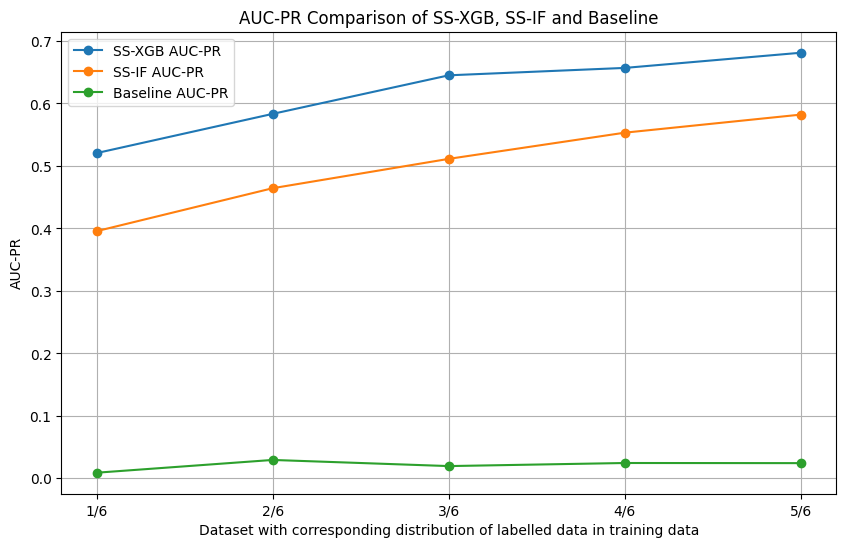

In [105]:
import matplotlib.pyplot as plt

custom_labels = ['1/6', '2/6', '3/6', '4/6', '5/6']

plt.figure(figsize=(10, 6))

plt.plot(results_ss_xgb_df['Dataset'], results_ss_xgb_df['AUC-PR'], marker='o', label='SS-XGB AUC-PR')
plt.plot(results_ss_ifo_df['Dataset'], results_ss_ifo_df['AUC-PR'], marker='o', label='SS-IF AUC-PR')
plt.plot(results_baseline_df['Dataset'], results_baseline_df['AUC-PR'], marker='o', label='Baseline AUC-PR')
plt.title('AUC-PR Comparison of SS-XGB, SS-IF and Baseline')
plt.xlabel('Dataset with corresponding distribution of labelled data in training data')
plt.ylabel('AUC-PR')
plt.xticks(ticks=results_ss_xgb_df['Dataset'], labels=custom_labels)  # Adding custom x-axis labels
plt.legend()
plt.grid(True)
plt.show()
